In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Read the data and some data cleaning

In [110]:
train=pd.read_csv('../input/titanic/train.csv')
test=pd.read_csv('../input/titanic/test.csv')
all_data=pd.concat([train,test],axis=0)
all_data.head(-10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
403,1295,NaN,1,"Carrau, Mr. Jose Pedro",male,17.0,0,0,113059,47.1000,NaN,S
404,1296,NaN,1,"Frauenthal, Mr. Isaac Gerald",male,43.0,1,0,17765,27.7208,D40,C
405,1297,NaN,2,"Nourney, Mr. Alfred (Baron von Drachstedt"")""",male,20.0,0,0,SC/PARIS 2166,13.8625,D38,C
406,1298,NaN,2,"Ware, Mr. William Jeffery",male,23.0,1,0,28666,10.5000,NaN,S


In [111]:
len(train)

891

Check the missing values of training set.

In [112]:
all_data.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

In [113]:
# Fill in NaN value with 'No Cabin'
all_data['Cabin']=all_data.Cabin.fillna('No Cabin')
all_data.Cabin.value_counts()

No Cabin           1014
C23 C25 C27           6
G6                    5
B57 B59 B63 B66       5
C78                   4
                   ... 
C49                   1
B94                   1
D6                    1
B101                  1
A31                   1
Name: Cabin, Length: 187, dtype: int64

I am very curious about which cabin has the highest survival rate, so I calculate the survival rates of each cabin and rank them from high to low.

In [114]:
# Calculation of survival rates for each cabin and then sort them descendingly
survive_by_cabin=train[['Survived','Cabin']].groupby(['Cabin']).mean()
survive_by_cabin.sort_values('Survived',ascending=False)

,Survived
Cabin,
C62 C64,1.0
D21,1.0
D17,1.0
D19,1.0
C148,1.0
...,...
C46,0.0
C30,0.0
C128,0.0


In [115]:
# Cabins that all members survived
survive_by_cabin[survive_by_cabin.Survived==1].head()

,Survived
Cabin,
A16,1.0
A20,1.0
A23,1.0
A26,1.0
A31,1.0


So we can see that some of the passengers have multiple cabins, however, those cabins have the same initial character, so we can extract it as the "Cabin" information. Otherwise, if we want to get dummy variable for "Cabin", it will result in very sparse data matrix.

In [116]:
all_data.Cabin=all_data.Cabin.apply(lambda x: x.split(' ')[0][0])
train.Cabin.value_counts()

G6             4
C23 C25 C27    4
B96 B98        4
F2             3
F33            3
              ..
D45            1
B86            1
A31            1
C85            1
C47            1
Name: Cabin, Length: 147, dtype: int64

This part I just want to make passengers name look cleaner therefore I split the name into prefix, first name and last name.

In [117]:
#Parsing the names
all_data['Last Name']=all_data['Name'].apply(lambda x:x.split(',')[0].strip())
all_data['Prefix']= all_data['Name'].apply(lambda x:x.split(',')[1].split('.')[0].strip())
all_data['First Name']=all_data['Name'].apply(lambda x:x.split('.')[1])
all_data['First Name']=all_data['First Name'].apply(lambda x:x.split()[0].strip())

In [118]:
all_data.Prefix.value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Dr                8
Rev               8
Col               4
Mlle              2
Ms                2
Major             2
Dona              1
Don               1
Mme               1
Jonkheer          1
Lady              1
the Countess      1
Capt              1
Sir               1
Name: Prefix, dtype: int64

At this point we can drop Name column and also Ticket since we already have Pclass and Cabin.

In [119]:
#Drop column 'Name' and 'Ticket'
all_data.drop(['Name','Ticket'],inplace=True,axis=1)

For data integration purpose, here I use "Family" to represent the total family memebers of a passenger which equals to his/her siblings/spouses plus parents/children.

In [120]:
all_data['Family']=all_data.SibSp+all_data.Parch

Check missing values for other features

In [121]:
all_data.loc[:, all_data.isnull().any()].columns

Index(['Survived', 'Age', 'Fare', 'Embarked'], dtype='object')

Impute the mode of "Embarked" for missing "Embarked" value and we will leave age to be filled in since the imputation can be tricky.

In [122]:
all_data.Embarked.fillna(all_data.Embarked.value_counts().idxmax(),inplace=True)

In [123]:
all_data.Fare.fillna(all_data.Fare.median(),inplace=True)

Again, check the missing values

In [124]:
all_data.isnull().sum()

PassengerId      0
Survived       418
Pclass           0
Sex              0
Age            263
SibSp            0
Parch            0
Fare             0
Cabin            0
Embarked         0
Last Name        0
Prefix           0
First Name       0
Family           0
dtype: int64

Good! There is no more missing values other than 'Age' and let us have a look at the cleaned dataset.

# Exploratory Data Analysis

First, I want to see if there is a different age distribution between survivors and non-survivors. 

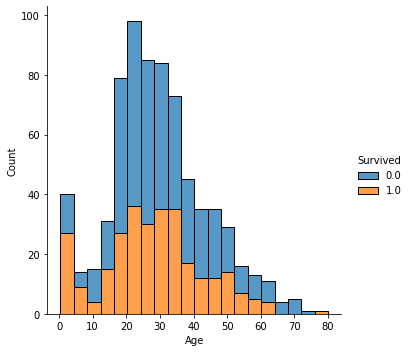

In [125]:
sns.displot(all_data[0:891],x='Age',hue='Survived',multiple='stack')

One can see from the above histogram that there is no huge differences between those two groups (just eye test). And for children (0-10), the survival rates will be much higher than other age groups (almost 50%).

For distribution of fare, we can see it is not normal (right-skewed), therefore, we need to do a bit of transformation.

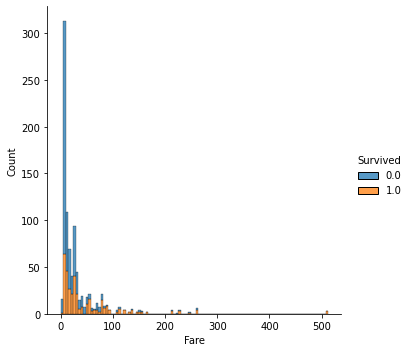

In [126]:
sns.displot(all_data[0:891],x='Fare',hue='Survived',multiple='stack')

Then we should look at gender differences.

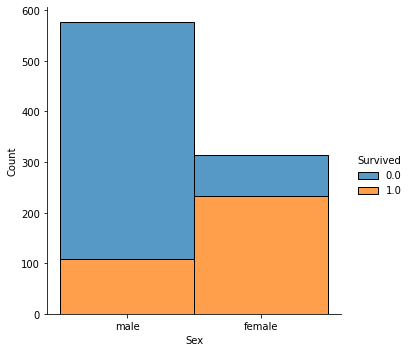

In [127]:
sns.displot(all_data[0:891],x='Sex',hue='Survived',multiple='stack')

It is clear that females have a higher survival rate than males. We should admire those people who give the chance of survival to children and women!

Let's see if you will have a higher chance to survive if you have more family members.

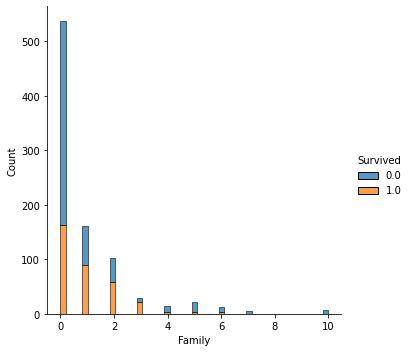

In [128]:
sns.displot(all_data[0:891],x="Family",hue='Survived',multiple='stack')

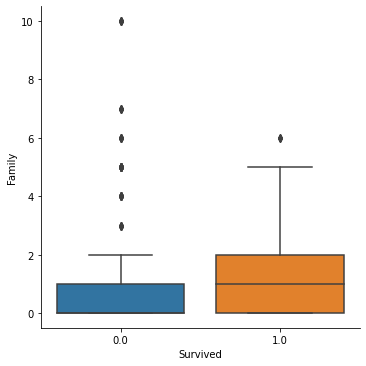

In [129]:
sns.catplot(x="Survived",y="Family",kind='box',data=all_data[0:891])

For survival group, either you are alone or you have a relatively small family size (2-3), you will more likely to survive. For non-survivors, most of them are alone or only have one family member, so they may give their chance of survival to the other one.

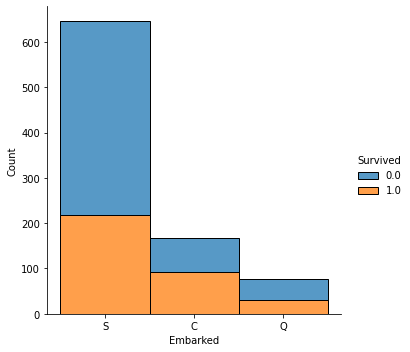

In [130]:
sns.displot(all_data[0:891],x='Embarked',hue='Survived',multiple='stack')

Seems like people embarked from Cherbourg or Queenstown are more likely to be saved.

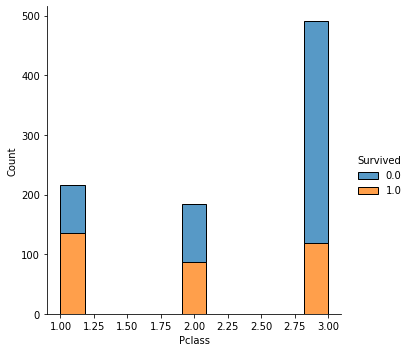

In [131]:
sns.displot(all_data[0:891],x='Pclass',hue='Survived',multiple='stack')

It is sad to see that lower class people has a lower chance to survive.

<AxesSubplot:>

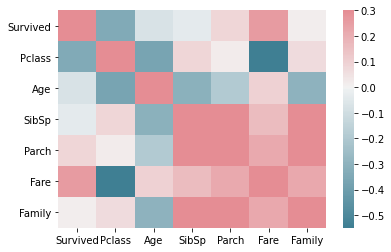

In [132]:
train_corr=all_data[0:891].iloc[:,1:].corr()
cmap=sns.diverging_palette(220,10,as_cmap=True)
sns.heatmap(train_corr,vmax=.3,center=0,cmap=cmap)

It can be observed from above heatmap that age and ticket class has negative correlation with survival and family related factors as well as fare are positively correlate to survival.

# Feature Engineering

One thing to do is to fill in the missing values for "Age", the other things like getting dummies for some categorical variables.

## Missing value imputation

For missing values we have different imputation method, like mean or median for numerical variable, mode for categorical variable (like I did for "Embarked" in the beginning). Here, I think we can take a step further, not just impute mean or median for age, we can take family information into consideration to impute age. For example, if a child will more likely to have parents on board, no spouse, few siblings. So here I choose to use KNN to impute age.

In [133]:
from sklearn.impute import KNNImputer
imputer=KNNImputer(n_neighbors=10)
all_data["Age"]=pd.DataFrame(imputer.fit_transform(all_data[["Age","SibSp","Parch"]]),columns=["Age","SibSp","Parch"])["Age"].astype(int)

In [134]:
all_data.isnull().sum()

PassengerId      0
Survived       418
Pclass           0
Sex              0
Age              0
SibSp            0
Parch            0
Fare             0
Cabin            0
Embarked         0
Last Name        0
Prefix           0
First Name       0
Family           0
dtype: int64

## Normalization of Numerical variables

From above EDA, we know "Fare" is right-skewed distributed, therefore, we need to do Box-Cox transformation to make it normalized.

In [135]:
all_data['Fare']=np.log(all_data['Fare']+1)

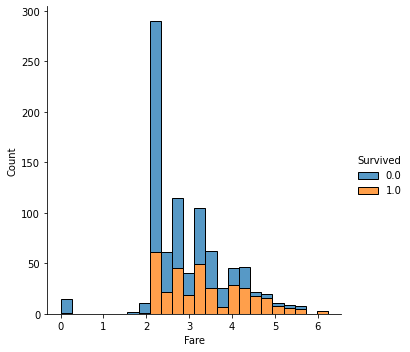

In [136]:
sns.displot(all_data[0:891],x='Fare',hue='Survived',multiple='stack')

Also, standardize "Age":

In [137]:
from sklearn.preprocessing import StandardScaler
all_data["Age"]=pd.DataFrame(StandardScaler().fit_transform(all_data[["Age"]]))

## Other feature engineering

In [138]:
all_data["Prefix"] = all_data["Prefix"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
all_data["Prefix"] = all_data["Prefix"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
all_data["Prefix"] = all_data["Prefix"].astype(int)
X_train_reduced = all_data.drop(['PassengerId','Survived','Last Name','First Name'],axis=1)
y_train_reduced=train["Survived"]
X_train_reduced = pd.get_dummies(X_train_reduced, columns = ["Prefix"],prefix="Prefix")
X_train_reduced = pd.get_dummies(X_train_reduced, columns = ["Cabin"],prefix="Cabin")
X_train_reduced = pd.get_dummies(X_train_reduced, columns = ["Embarked"],prefix="Embarked")
X_train_reduced = pd.get_dummies(X_train_reduced, columns = ["Sex"],prefix="Sex")
X_train_reduced = pd.get_dummies(X_train_reduced, columns = ["Pclass"],prefix="Pclass")
X_test=X_train_reduced[891:]
X_train_reduced=X_train_reduced[0:891]

We can see that the distribution is much more normal than before.

# Modeling

## Logistic Regression

In [139]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [140]:
logistic=LogisticRegression()
logistic.fit(X_train_reduced,y_train_reduced)

LogisticRegression()

In [141]:
cross_val_score(logistic, X_train_reduced, y_train_reduced, scoring = "accuracy", cv = 10, n_jobs=-1).mean()

0.8283021223470662

## Random Forest Regressor

In [142]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
grid_rf = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
random_forest=RandomForestClassifier()
random_search_rf=RandomizedSearchCV(estimator = random_forest, param_distributions = grid_rf, n_iter = 100, cv = 3, verbose=2, random_state=42,n_jobs=-1)
random_search_rf.fit(X_train_reduced,y_train_reduced)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [143]:
random_search_rf.best_score_

0.8305274971941637

In [144]:
random_forest_final = random_search_rf.best_estimator_
random_forest_final.fit(X_train_reduced,y_train_reduced)
cross_val_score(random_forest_final, X_train_reduced, y_train_reduced, scoring = "accuracy", cv = 10, n_jobs=-1).mean()

0.8316853932584269

## XGBoost

In [145]:
from xgboost import XGBClassifier
grid_xgb=  {"n_estimators"    : range(8, 20),
              "learning_rate"   : [ 0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
              "max_depth"       : [ 3, 4, 5, 6, 8, 10, 12, 15 ],
              "colsample_bytree": [ 0.3, 0.4, 0.5 , 0.7 ] }
xgb_clf=XGBClassifier(use_label_encoder =False,eval_metric='error')
random_search_xgb=RandomizedSearchCV(estimator=xgb_clf, param_distributions = grid_xgb, scoring = "accuracy", n_iter = 50, cv = 3,random_state=42)
random_search_xgb.fit(np.ascontiguousarray(X_train_reduced),y_train_reduced)

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           eval_metric='error', gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=No...
                                           random_state=None, reg_alpha=None,
                                           reg_lambda=None,
                                           

In [146]:
xgb_clf_final=random_search_xgb.best_estimator_

In [147]:
random_search_xgb.best_score_

0.8372615039281707

In [148]:
cross_val_score(xgb_clf_final, X_train_reduced, y_train_reduced, scoring = "accuracy", cv = 10,n_jobs=-1).mean()

0.8372908863920101

## Support Vector Classifier

In [149]:
from sklearn.svm import SVC
sv_clf=SVC()
grid_svc={'gamma'     :[0.1, 0.5, 1, 5, 10],
          'C' :[10, 1, 0.1, 0.01, 0.001],
          'kernel':['linear', 'rbf']
         }
random_search_svc=RandomizedSearchCV(sv_clf,grid_svc,cv=3,scoring='accuracy',n_jobs=-1,random_state=42,n_iter=20)
random_search_svc.fit(X_train_reduced,y_train_reduced)
random_search_svc.best_score_

0.8226711560044894

In [150]:
svc_final=random_search_svc.best_estimator_

In [151]:
svc_final.fit(X_train_reduced,y_train_reduced)
cross_val_score(svc_final, X_train_reduced, y_train_reduced, scoring = "accuracy", cv = 10,n_jobs=-1).mean()

0.819338327091136

## Voting Classifier

In [152]:
from sklearn.ensemble import VotingClassifier
voting_clf=VotingClassifier(
        estimators=[('log',logistic),('rf',random_forest_final),('xgboost',xgb_clf_final),('svc',svc_final)],
        voting='hard')
voting_clf.fit(X_train_reduced,y_train_reduced)
cross_val_score(voting_clf, X_train_reduced, y_train_reduced, scoring = "accuracy", cv = 10,n_jobs=-1).mean()

0.8328214731585518

# Output predictions on test set

In [153]:
X_test.columns

Index(['Age', 'SibSp', 'Parch', 'Fare', 'Family', 'Prefix_0', 'Prefix_1',
       'Prefix_2', 'Prefix_3', 'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D',
       'Cabin_E', 'Cabin_F', 'Cabin_G', 'Cabin_N', 'Cabin_T', 'Embarked_C',
       'Embarked_Q', 'Embarked_S', 'Sex_female', 'Sex_male', 'Pclass_1',
       'Pclass_2', 'Pclass_3'],
      dtype='object')

In [154]:
Survived=xgb_clf_final.predict(np.ascontiguousarray(X_test))

In [155]:
results = pd.concat([test["PassengerId"],pd.Series(Survived,name="Survived")],axis=1)
results.to_csv("xgboost_results.csv",index=False)

In [156]:
results2=pd.concat([test["PassengerId"],pd.Series(voting_clf.predict(X_test),name="Survived")],axis=1)
results2.to_csv("voting_clf_results.csv",index=False)

/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


In [157]:
results3=pd.concat([test["PassengerId"],pd.Series(random_forest_final.predict(X_test),name="Survived")],axis=1)
results3.to_csv("random_forest_results.csv",index=False)

In [158]:
results4=pd.concat([test["PassengerId"],pd.Series(svc_final.predict(X_test),name="Survived")],axis=1)
results4.to_csv("svc_results.csv",index=False)